In [2]:
# Libs
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import numpy as np

# Data Loading

In [3]:
df_dw = pd.read_csv('../Data/DW/DISABILITY_WEIGHTS.csv', quotechar='"')
print(df_dw.head())

                                        Sequela Name  \
0  HIV/AIDS -  Drug-susceptible Tuberculosis with...   
1  HIV/AIDS -  Drug-susceptible Tuberculosis with...   
2  HIV/AIDS -  Drug-susceptible Tuberculosis with...   
3  HIV/AIDS -  Drug-susceptible Tuberculosis with...   
4  HIV/AIDS - Multidrug-resistant Tuberculosis wi...   

                                 Health State Name  \
0                       Tuberculosis, HIV infected   
1      Tuberculosis, HIV infected and anemia, mild   
2  Tuberculosis, HIV infected and anemia, moderate   
3    Tuberculosis, HIV infected and anemia, severe   
4                       Tuberculosis, HIV infected   

                        Health State Lay Description      Mean     Lower  \
0  has a persistent cough and fever, shortness of...  0.408459  0.273579   
1                                      (combined DW)  0.410696  0.278063   
2                                      (combined DW)  0.438663  0.306546   
3                                 

# Cleaning

In [4]:
df_dw["Health State Lay Description"] = df_dw["Health State Lay Description"].astype(str).str.lower()

In [5]:
df_dw = df_dw[
    (~df_dw["Health State Lay Description"].str.contains(r'\bdw\b')) &
    (df_dw['Health State Lay Description'] != 'nan') &
    (df_dw['Health State Lay Description'].str.strip() != '')
]

In [6]:
# Duplicates
duplicate_counts = df_dw.duplicated().sum()
print(duplicate_counts)

0


In [7]:
# Duplicate Descriptions for different sequelas
duplicate_counts = df_dw['Health State Lay Description'].duplicated().sum()
print(duplicate_counts)

830


In [8]:
inconsistent_means = (
    df_dw.groupby('Health State Lay Description')['Mean']
    .nunique()
    .reset_index()
)

inconsistent_means = inconsistent_means[inconsistent_means['Mean'] > 1]
print(f"Descriptions with inconsistent Mean values: {len(inconsistent_means)}")
print(inconsistent_means)

Descriptions with inconsistent Mean values: 0
Empty DataFrame
Columns: [Health State Lay Description, Mean]
Index: []


In [9]:
df_dw = df_dw.drop_duplicates(subset=['Health State Lay Description'])

In [10]:
print(df_dw.info())

<class 'pandas.core.frame.DataFrame'>
Index: 174 entries, 0 to 2255
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sequela Name                  174 non-null    object 
 1   Health State Name             174 non-null    object 
 2   Health State Lay Description  174 non-null    object 
 3   Mean                          174 non-null    float64
 4   Lower                         174 non-null    float64
 5   Upper                         174 non-null    float64
dtypes: float64(3), object(3)
memory usage: 9.5+ KB
None


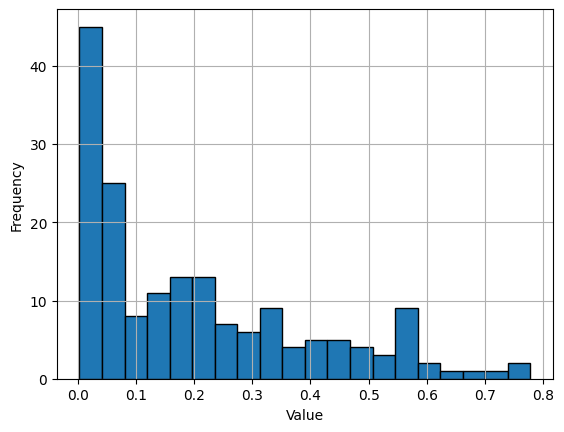

In [11]:
# mean dist
plt.hist(df_dw['Mean'], bins=20, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("figs/GBD_DW_hist.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
print(df_dw["Sequela Name"].isna().sum())
print(df_dw["Health State Name"].isna().sum())
print(df_dw["Health State Lay Description"].isna().sum())
print(df_dw["Mean"].isna().sum())
print(df_dw["Lower"].isna().sum())
print(df_dw["Upper"].isna().sum())

0
0
0
0
0
0


# Splitting Sentences

In [13]:
def split_symptoms(text):
    text = text.lower().strip()
    text = re.sub(r'\band\b', ',', text)
    text = re.sub(r'\.', ', ', text)
    text = re.sub(r';', ', ', text)
    text = re.sub(r'\s*,\s*', ', ', text)
    return [s.strip() for s in text.split(',') if s.strip()]

In [14]:
df_dw['Split Symptoms'] = df_dw["Health State Lay Description"].apply(split_symptoms)

In [45]:
# Check accuracy
random_idx = random.choice(df_dw.index)
original_text = df_dw.loc[random_idx, "Health State Lay Description"]
split_list = df_dw.loc[random_idx, "Split Symptoms"]

print("Original Description:")
print(original_text)
print("\nSplit Symptoms:")
print(split_list)

Original Description:
has some difficulty in moving around, and difficulty in lifting and holding objects, dressing and sitting upright, but is able to walk without help.

Split Symptoms:
['has some difficulty in moving around', 'difficulty in lifting', 'holding objects', 'dressing', 'sitting upright', 'but is able to walk without help']


# Exporting

In [77]:
df_dw.to_feather('../Data/DW/df_dw_filtered.feather')
df_dw.to_excel('../Data/DW/df_dw_filtered.xlsx', index=False)